In [2]:
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import transforms
import torchvision.models as models  
from torchvision.transforms import Resize, RandomAffine, ToTensor, ToPILImage,  RandomErasing
from torchvision.transforms import functional as F

from transformers import get_cosine_schedule_with_warmup

import random
from PIL import Image, ImageEnhance 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import timm

In [3]:
# CSV FILE PATHS MAPPING
# Paths to the CSV files and image folder
train_csv_path = 'bookcover30/Task1/book30-listing-train.csv'
test_csv_path = 'bookcover30/Task1/book30-listing-test.csv'
image_folder = 'bookcover30/bookcover_images'

# Load train and test data from CSV files
train_data = pd.read_csv(train_csv_path, header=None, encoding='ISO-8859-1')
test_data = pd.read_csv(test_csv_path, header=None, encoding='ISO-8859-1')

# Extract text, label, and filename columns
# Column indices are based on the CSV structure 0-based
# Titles are in column 4
# Labels are in column 7
# Image filenames are in column 2

train_texts = train_data.iloc[:, 3].tolist() 
train_titles = train_data.iloc[:, 3].tolist() 
train_labels = train_data.iloc[:, 6].tolist()  
train_filenames = train_data.iloc[:, 1].tolist()  

test_texts = test_data.iloc[:, 3].tolist()
test_titles = test_data.iloc[:, 3].tolist()
test_labels = test_data.iloc[:, 6].tolist()
test_filenames = test_data.iloc[:, 1].tolist() 

# Prepend the image folder path to the filenames for both train and test data

train_filenames = [os.path.join(image_folder, fname) for fname in train_filenames]
test_filenames = [os.path.join(image_folder, fname) for fname in test_filenames]

# Get the unique labels and create a mapping
label_names = [str(label) for label in sorted(np.unique(train_labels))]
label_to_index = {name: index for index, name in enumerate(label_names)}

# Encode the labels
train_labels_encoded = np.array([label_to_index[label] for label in train_labels])
test_labels_encoded = np.array([label_to_index[label] for label in test_labels])

In [4]:
# COLOR SPACE CONVERSION
COLOR_CONVERSIONS = {
    "RGB": None,
    "XYZ": cv2.COLOR_RGB2XYZ,
    "YCbCr": cv2.COLOR_RGB2YCrCb,
    "LAB": cv2.COLOR_RGB2Lab,
    "HSV": cv2.COLOR_RGB2HSV,
    "YUV": cv2.COLOR_RGB2YUV,
    "LUV": cv2.COLOR_RGB2Luv
}

def convert_color_space(image, color_space):
    """Convert RGB image to a specified color space."""
    if color_space == "RGB":
        return image
    return cv2.cvtColor(image, COLOR_CONVERSIONS[color_space])

In [5]:
# DATA AUGMENTATION
def data_augmentation(image, rotation=False, blur=False, affine=False):
    image = Image.fromarray(image)  # Convert NumPy to PIL for PIL-based transforms
    pil_transforms = []  # Define list for PIL-based transforms

    # 🔹 Random Rotation
    if rotation:
        angle = np.random.uniform(-15, 15)
        image = image.rotate(angle)

    # 🔹 Random Affine Transformation (Shear)
    if affine:
        pil_transforms.append(RandomAffine(degrees=0, shear=10))

    # Apply PIL-based transformations AFTER adding them
    if pil_transforms:
        image = transforms.Compose(pil_transforms)(image)

    # Convert back to NumPy after augmentations
    image = np.array(image)

    # 🔹 Apply Gaussian Blur
    if blur:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    return image  


In [6]:
# PREPROCESSING
def preprocess_image(image_path, color_spaces, img_size=(224, 224), augmentations=None, is_test=False):
    bgr_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    tensors = []
    for space in color_spaces:
        converted = convert_color_space(rgb_image, space)  # Convert to target color space
        
        # 🔹 Convert to PIL before applying PIL-based augmentations
        image = Image.fromarray(converted)
        
        # 🔹 Apply augmentations only during training (excluding "erasing")
        if not is_test and augmentations:
            aug_params = {k: v for k, v in augmentations.items() if k != "erasing"}  # Exclude "erasing"
            converted = data_augmentation(np.array(image), **aug_params)  # Ensure NumPy format

        # Resize AFTER augmentations
        resized = cv2.resize(converted, img_size, interpolation=cv2.INTER_LINEAR)

        # Convert to PyTorch tensor
        tensor_image = ToTensor()(Image.fromarray(resized))

        # 🔹 Apply `RandomErasing` (Only in training mode)
        if not is_test and augmentations.get("erasing", False):
            random_erasing = RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)
            tensor_image = random_erasing(tensor_image)

        tensors.append(tensor_image)
    
    return tensors

In [7]:
# DATASET FUNCTIONS
class TrainDataset(Dataset):
    def __init__(self, image_paths, labels, color_spaces, img_size, augmentations=None):
        self.image_paths = image_paths
        self.labels = labels
        self.color_spaces = color_spaces
        self.img_size = img_size
        self.augmentations = augmentations if augmentations else {}

    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image_tensors = preprocess_image(image_path, self.color_spaces, self.img_size, self.augmentations, is_test=False)  
        return image_tensors, label

class TestDataset(Dataset):
    def __init__(self, image_paths, labels, color_spaces, img_size):
        self.image_paths = image_paths
        self.labels = labels
        self.color_spaces = color_spaces
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image_tensors = preprocess_image(image_path, self.color_spaces, self.img_size, is_test=True)

        # 🔹 If only one model is used, return a single tensor instead of a list
        if len(image_tensors) == 1:
            return image_tensors[0], label  # Return a single tensor
        
        return image_tensors, label  # Return multiple tensors for Parallel-ViT setup

In [ ]:
# SETTINGS
color_spaces = ["RGB", "XYZ"]
img_size = (224, 224)
output_dir = "MER/02_parallelvit"
used_models = ["vit", "vit"]
cnn_name = "resnext101_32x4d"
vit_name = "vit_base_patch16_224"

augmentations={"rotation": True, "blur": False, "erasing": False, "affine": True}

In [9]:
# DATASET INITIALIZATION

# Train Dataset (Uses Color Spaces & Augmentations)
train_dataset = TrainDataset(train_filenames, train_labels_encoded, color_spaces=color_spaces, img_size=img_size, 
    augmentations=augmentations
)

# Test Dataset (Same Preprocessing but No Augmentations)
test_dataset = TestDataset(test_filenames, test_labels_encoded, color_spaces=color_spaces, img_size=img_size)

# Dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# PARALLEL VIT MODEL
class HybridModel(nn.Module):
    def __init__(self, num_classes=30, model_config=["cnn"], cnn_variant="resnext50_32x4d", vit_variant="vit_base_patch16_224", fusion_reduction=2, dropout_rate=0.1):
        super(HybridModel, self).__init__()
        self.model_config = model_config
        self.models = nn.ModuleList()
        self.feature_dims = []
        self.fusion_reduction = fusion_reduction
        self.dropouts = nn.ModuleList()
        self.cnn_variant = cnn_variant
        self.vit_variant = vit_variant


        # Load CNN Model 
        cnn_count = model_config.count("cnn")
        for _ in range(cnn_count):
            cnn_model = timm.create_model(cnn_variant, pretrained=True, num_classes=0)  # No classifier
            self.models.append(cnn_model)
            self.feature_dims.append(cnn_model.num_features)
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Load ViT Model
        vit_count = model_config.count("vit")
        for _ in range(vit_count):
            vit_model = timm.create_model(vit_variant, pretrained=True, num_classes=0)  # No classifier layer
            self.models.append(vit_model)
            self.feature_dims.append(vit_model.num_features)
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Feature fusion if multiple models are used
        if len(self.models) > 1:
            self.fusion_dim = sum(self.feature_dims)
            self.fusion_fc = nn.Linear(self.fusion_dim, self.fusion_dim // self.fusion_reduction)
        else:
            self.fusion_fc = None  

        # Final classifier
        final_feature_dim = (self.fusion_dim // self.fusion_reduction) if self.fusion_fc else self.feature_dims[0]
        self.classifier = nn.Linear(final_feature_dim, num_classes)
        
    def forward(self, *inputs):
        if len(self.models) != len(inputs):
            raise ValueError(f"Model input mismatch: Expected {len(self.models)} inputs but got {len(inputs)}.")
    
        features = []
        for model, inp, dropout in zip(self.models, inputs, self.dropouts):
            model_name = model._get_name().lower()
            x = model(inp)  
            x = x.mean(dim=1) if 'vit' in model._get_name().lower() else torch.flatten(x, 1)
    
            x = dropout(x)  # Apply dropout
            features.append(x)

        if len(features) > 1:
            x = torch.cat(features, dim=1)
            x = self.fusion_fc(x)
        else:
            x = features[0]
    
        x = self.classifier(x)
        return x

In [11]:
# TRAINING LOOP
import logging 
# 🔹 Configure Logging
logging.basicConfig(
    filename=f"logs/{output_dir}.log",  # Save logs to this file
    filemode="a",  # Append logs each run 
    format="%(asctime)s - %(levelname)s - %(message)s",  
    level=logging.INFO  # Set logging level
)
logger = logging.getLogger()

def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, use_scheduler, warmup):
    model.to(device)
    train_losses = []
    test_accuracies_top1 = []
    test_accuracies_top3 = []

    if use_scheduler:
        num_training_steps = len(train_loader) * num_epochs
        num_warmup_steps = int(warmup * num_training_steps)  
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, total = 0.0, 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for images, labels in progress_bar:
            images = [img.to(device) for img in images]
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(*images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if use_scheduler:
                scheduler.step()
                
            running_loss += loss.item()
            total += labels.size(0)
            
            progress_bar.set_postfix(loss=running_loss / (total / len(labels)))
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # ✅ Log training loss
        log_msg = f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}"
        print(log_msg)
        logger.info(log_msg) 
        
        current_lr = optimizer.param_groups[0]['lr']
        if use_scheduler:
            print(f"Learning Rate: {current_lr:.8f}")
        
        # ✅ Evaluate on test set
        test_acc1, test_acc3, all_preds, all_labels = evaluate_model(model, test_loader, device)
        test_accuracies_top1.append(test_acc1)
        test_accuracies_top3.append(test_acc3)

        # ✅ Log evaluation results
        eval_msg = f"Epoch [{epoch+1}/{num_epochs}], Test Top-1 Accuracy: {test_acc1:.2f}%, Test Top-3 Accuracy: {test_acc3:.2f}%"
        print(eval_msg)
        logger.info(eval_msg)

    print("Training complete!")
    logger.info("Training complete!")

    return train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels

In [ ]:
# MULTI-RUNS FUNCTION
def run_multiple_times(train_loader, test_loader, num_epochs=10, use_scheduler=False, warmup=0.2, num_runs=3):
    best_top1 = -float('inf')  # Initialize to a very low value
    best_top3 = 0
    saved_loss, saved_top1, saved_top3, preds, labels = [], [], [], [], []
    
    # Initialize best model state dictionary
    best_model_state_dict = None

    for run in range(1, num_runs + 1):
        separator = f"\n{'=' * 40}\n RUN {run} / {num_runs} \n{'=' * 40}\n"
        print(separator)
        logger.info(separator)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        model = HybridModel(
            num_classes=30,
            model_config=used_models, 
            cnn_variant=cnn_name,
            vit_variant=vit_name,
            fusion_reduction=1,
            dropout_rate=0.5,
        ).to(device)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        
        # Define optimizer using Adam
        optimizer = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-3)
        
        # Train the model
        train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels = train_model(
            model, train_loader, test_loader, criterion, optimizer, device, num_epochs, use_scheduler, warmup
        )
        
        # Get the last value of test_accuracies_top1 for the current run
        current_top1 = test_accuracies_top1[-1]
        
        # Check if the current run has the best top-1 accuracy so far
        if current_top1 > best_top1:
            best_top1 = current_top1
            best_top3 = test_accuracies_top3[-1]  # Update top-3 accuracy
            
            # Save the results for the best run
            saved_loss = train_losses
            saved_top1 = test_accuracies_top1
            saved_top3 = test_accuracies_top3
            preds = all_preds
            labels = all_labels

            best_model_state_dict = model.state_dict()  # Save the model state
            
            # Optionally, print out the best performance
            print(f"New best top-1 accuracy: {best_top1:.4f}. Saving the model.")
        
    # After all runs, save the best model if it's updated
    if best_model_state_dict is not None:
        # Define save paths
        state_dict_path = f"saves/models/{output_dir}.pth"  # Saves only state_dict
        
        # Save only state_dict
        torch.save(best_model_state_dict, state_dict_path)
        
        print(f"Best model saved at {state_dict_path}")
        logger.info(f"Best model saved at {state_dict_path}")
    else:
        print("No model was saved.")
        logger.info("No model was saved.")

    return saved_loss, saved_top1, saved_top3, preds, labels

In [ ]:
# EVAL-MODEL FUNCTION
def evaluate_model(model, test_loader, device):
    model.eval()
    correct_top1, correct_top3, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            labels = labels.to(device)

            # 🔹 Handle Single Model (CNN-only or ViT-only)
            if isinstance(images, torch.Tensor):
                images = images.to(device)
                outputs = model(images)

            # 🔹 Handle Multiple Models (CNN-ViT, ViT-ViT, CNN-ViT-ViT)
            elif isinstance(images, list):
                images = [img.to(device) for img in images]
                outputs = model(*images)

            else:
                raise ValueError(f"Unexpected input format: {type(images)}")  # Debugging safeguard

            # 🔹 Compute Top-1 and Top-3 Accuracy
            _, pred_top1 = outputs.topk(1, dim=1, largest=True, sorted=True)
            _, pred_top3 = outputs.topk(3, dim=1, largest=True, sorted=True)

            correct_top1 += (pred_top1.squeeze() == labels).sum().item()
            correct_top3 += (labels.unsqueeze(1) == pred_top3).sum().item()
            total += labels.size(0)

            all_preds.extend(pred_top1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 🔹 Compute Accuracy Percentages
    test_acc1 = 100 * correct_top1 / total
    test_acc3 = 100 * correct_top3 / total

    print(f"Test Top-1 Accuracy: {test_acc1:.2f}% | Test Top-3 Accuracy: {test_acc3:.2f}%")
    return test_acc1, test_acc3, all_preds, all_labels

In [ ]:
# PLOT LOSS/CONF-MATRIX FUNCTION
def plot_training_results(train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels, output_dir):
    # Plot training loss and accuracy
    plt.figure(figsize=(12, 4))
    epochs = range(1, num_epochs + 1)
    
    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", linestyle='-', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    
    # Plot Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies_top1, label="Test Top-1 Accuracy", color='green')
    plt.plot(epochs, test_accuracies_top3, label="Test Top-3 Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()

    # Save the figure as a file
    plt.savefig(f"saves/graphs/{output_dir}_loss-accuracy.png", bbox_inches='tight')  # Save as PNG
    plt.show()
    plt.close()  # Close the current figure

    # Convert lists to NumPy arrays for confusion matrix
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Save the confusion matrix as a file
    plt.savefig(f"saves/graphs/{output_dir}_conf-matrix.png", bbox_inches='tight')  # Save as PNG
    plt.show()
    plt.close()  # Close the current figure

    print(f"Figures saved to {output_dir}")


 RUN 1 / 5 



Epoch [1/10], Loss: 3.2254
Learning Rate: 0.00000150


Test Top-1 Accuracy: 23.32% | Test Top-3 Accuracy: 43.00%
Epoch [1/10], Test Top-1 Accuracy: 23.32%, Test Top-3 Accuracy: 43.00%


Epoch [2/10], Loss: 2.6249
Learning Rate: 0.00000300


Test Top-1 Accuracy: 29.70% | Test Top-3 Accuracy: 50.51%
Epoch [2/10], Test Top-1 Accuracy: 29.70%, Test Top-3 Accuracy: 50.51%


Epoch [3/10], Loss: 2.3824
Learning Rate: 0.00000289


Test Top-1 Accuracy: 33.12% | Test Top-3 Accuracy: 55.54%
Epoch [3/10], Test Top-1 Accuracy: 33.12%, Test Top-3 Accuracy: 55.54%


Epoch [4/10], Loss: 2.2054
Learning Rate: 0.00000256


Test Top-1 Accuracy: 35.53% | Test Top-3 Accuracy: 56.61%
Epoch [4/10], Test Top-1 Accuracy: 35.53%, Test Top-3 Accuracy: 56.61%


Epoch [5/10], Loss: 2.0435
Learning Rate: 0.00000207


Test Top-1 Accuracy: 36.32% | Test Top-3 Accuracy: 57.91%
Epoch [5/10], Test Top-1 Accuracy: 36.32%, Test Top-3 Accuracy: 57.91%


Epoch [6/10], Loss: 1.8975
Learning Rate: 0.00000150


Test Top-1 Accuracy: 36.18% | Test Top-3 Accuracy: 58.02%
Epoch [6/10], Test Top-1 Accuracy: 36.18%, Test Top-3 Accuracy: 58.02%


Epoch [7/10], Loss: 1.7465
Learning Rate: 0.00000093


Test Top-1 Accuracy: 36.91% | Test Top-3 Accuracy: 58.46%
Epoch [7/10], Test Top-1 Accuracy: 36.91%, Test Top-3 Accuracy: 58.46%


Epoch [8/10], Loss: 1.6257
Learning Rate: 0.00000044


Test Top-1 Accuracy: 36.88% | Test Top-3 Accuracy: 58.74%
Epoch [8/10], Test Top-1 Accuracy: 36.88%, Test Top-3 Accuracy: 58.74%


Epoch [9/10], Loss: 1.5484
Learning Rate: 0.00000011


Test Top-1 Accuracy: 36.82% | Test Top-3 Accuracy: 58.33%
Epoch [9/10], Test Top-1 Accuracy: 36.82%, Test Top-3 Accuracy: 58.33%


Epoch [10/10], Loss: 1.5125
Learning Rate: 0.00000000


Test Top-1 Accuracy: 36.88% | Test Top-3 Accuracy: 58.26%
Epoch [10/10], Test Top-1 Accuracy: 36.88%, Test Top-3 Accuracy: 58.26%
Training complete!
New best top-1 accuracy: 36.8772. Saving the model.

 RUN 2 / 5 



Epoch [1/10], Loss: 3.2471
Learning Rate: 0.00000150


Test Top-1 Accuracy: 23.46% | Test Top-3 Accuracy: 42.86%
Epoch [1/10], Test Top-1 Accuracy: 23.46%, Test Top-3 Accuracy: 42.86%


Epoch [2/10], Loss: 2.6322
Learning Rate: 0.00000300


Test Top-1 Accuracy: 29.63% | Test Top-3 Accuracy: 50.82%
Epoch [2/10], Test Top-1 Accuracy: 29.63%, Test Top-3 Accuracy: 50.82%


Epoch [3/10], Loss: 2.3894
Learning Rate: 0.00000289


Test Top-1 Accuracy: 32.49% | Test Top-3 Accuracy: 54.18%
Epoch [3/10], Test Top-1 Accuracy: 32.49%, Test Top-3 Accuracy: 54.18%


Epoch [4/10], Loss: 2.2113
Learning Rate: 0.00000256


Test Top-1 Accuracy: 34.04% | Test Top-3 Accuracy: 55.19%
Epoch [4/10], Test Top-1 Accuracy: 34.04%, Test Top-3 Accuracy: 55.19%


Epoch [5/10], Loss: 2.0576
Learning Rate: 0.00000207


Test Top-1 Accuracy: 35.05% | Test Top-3 Accuracy: 57.04%
Epoch [5/10], Test Top-1 Accuracy: 35.05%, Test Top-3 Accuracy: 57.04%


Epoch [6/10], Loss: 1.9031
Learning Rate: 0.00000150


Test Top-1 Accuracy: 36.37% | Test Top-3 Accuracy: 58.14%
Epoch [6/10], Test Top-1 Accuracy: 36.37%, Test Top-3 Accuracy: 58.14%


Epoch [7/10], Loss: 1.7550
Learning Rate: 0.00000093


Test Top-1 Accuracy: 36.33% | Test Top-3 Accuracy: 58.05%
Epoch [7/10], Test Top-1 Accuracy: 36.33%, Test Top-3 Accuracy: 58.05%


Epoch [8/10], Loss: 1.6382
Learning Rate: 0.00000044


Test Top-1 Accuracy: 35.88% | Test Top-3 Accuracy: 58.00%
Epoch [8/10], Test Top-1 Accuracy: 35.88%, Test Top-3 Accuracy: 58.00%


Epoch [9/10], Loss: 1.5541
Learning Rate: 0.00000011


Test Top-1 Accuracy: 35.91% | Test Top-3 Accuracy: 57.54%
Epoch [9/10], Test Top-1 Accuracy: 35.91%, Test Top-3 Accuracy: 57.54%


Epoch [10/10], Loss: 1.5211
Learning Rate: 0.00000000


Test Top-1 Accuracy: 35.63% | Test Top-3 Accuracy: 57.47%
Epoch [10/10], Test Top-1 Accuracy: 35.63%, Test Top-3 Accuracy: 57.47%
Training complete!

 RUN 3 / 5 



Epoch [1/10], Loss: 3.2436
Learning Rate: 0.00000150


Test Top-1 Accuracy: 23.93% | Test Top-3 Accuracy: 43.02%
Epoch [1/10], Test Top-1 Accuracy: 23.93%, Test Top-3 Accuracy: 43.02%


Epoch [2/10], Loss: 2.6431
Learning Rate: 0.00000300


Test Top-1 Accuracy: 29.77% | Test Top-3 Accuracy: 51.37%
Epoch [2/10], Test Top-1 Accuracy: 29.77%, Test Top-3 Accuracy: 51.37%


Epoch [3/10], Loss: 2.3943
Learning Rate: 0.00000289


Test Top-1 Accuracy: 32.67% | Test Top-3 Accuracy: 55.11%
Epoch [3/10], Test Top-1 Accuracy: 32.67%, Test Top-3 Accuracy: 55.11%


Epoch [4/10], Loss: 2.2179
Learning Rate: 0.00000256


Test Top-1 Accuracy: 34.35% | Test Top-3 Accuracy: 56.18%
Epoch [4/10], Test Top-1 Accuracy: 34.35%, Test Top-3 Accuracy: 56.18%


Epoch [5/10], Loss: 2.0637
Learning Rate: 0.00000207


Test Top-1 Accuracy: 35.53% | Test Top-3 Accuracy: 56.98%
Epoch [5/10], Test Top-1 Accuracy: 35.53%, Test Top-3 Accuracy: 56.98%


Epoch [6/10], Loss: 1.9125
Learning Rate: 0.00000150


Test Top-1 Accuracy: 35.82% | Test Top-3 Accuracy: 57.91%
Epoch [6/10], Test Top-1 Accuracy: 35.82%, Test Top-3 Accuracy: 57.91%


Epoch [7/10], Loss: 1.7686
Learning Rate: 0.00000093


Test Top-1 Accuracy: 35.72% | Test Top-3 Accuracy: 57.58%
Epoch [7/10], Test Top-1 Accuracy: 35.72%, Test Top-3 Accuracy: 57.58%


Epoch [8/10], Loss: 1.6558
Learning Rate: 0.00000044


Test Top-1 Accuracy: 36.32% | Test Top-3 Accuracy: 57.84%
Epoch [8/10], Test Top-1 Accuracy: 36.32%, Test Top-3 Accuracy: 57.84%


Epoch [9/10], Loss: 1.5800
Learning Rate: 0.00000011


Test Top-1 Accuracy: 36.12% | Test Top-3 Accuracy: 57.95%
Epoch [9/10], Test Top-1 Accuracy: 36.12%, Test Top-3 Accuracy: 57.95%


Epoch [10/10], Loss: 1.5442
Learning Rate: 0.00000000


Test Top-1 Accuracy: 35.82% | Test Top-3 Accuracy: 57.89%
Epoch [10/10], Test Top-1 Accuracy: 35.82%, Test Top-3 Accuracy: 57.89%
Training complete!

 RUN 4 / 5 



Epoch [1/10], Loss: 3.2477
Learning Rate: 0.00000150


Test Top-1 Accuracy: 23.79% | Test Top-3 Accuracy: 42.40%
Epoch [1/10], Test Top-1 Accuracy: 23.79%, Test Top-3 Accuracy: 42.40%


Epoch [2/10], Loss: 2.6598
Learning Rate: 0.00000300


Test Top-1 Accuracy: 29.77% | Test Top-3 Accuracy: 51.14%
Epoch [2/10], Test Top-1 Accuracy: 29.77%, Test Top-3 Accuracy: 51.14%


Epoch [3/10], Loss: 2.4043
Learning Rate: 0.00000289


Test Top-1 Accuracy: 33.14% | Test Top-3 Accuracy: 54.37%
Epoch [3/10], Test Top-1 Accuracy: 33.14%, Test Top-3 Accuracy: 54.37%


Epoch [4/10], Loss: 2.2209
Learning Rate: 0.00000256


Test Top-1 Accuracy: 34.86% | Test Top-3 Accuracy: 56.79%
Epoch [4/10], Test Top-1 Accuracy: 34.86%, Test Top-3 Accuracy: 56.79%


Epoch [5/10], Loss: 2.0599
Learning Rate: 0.00000207


Test Top-1 Accuracy: 35.21% | Test Top-3 Accuracy: 57.00%
Epoch [5/10], Test Top-1 Accuracy: 35.21%, Test Top-3 Accuracy: 57.00%


Epoch [6/10], Loss: 1.9063
Learning Rate: 0.00000150


Test Top-1 Accuracy: 36.65% | Test Top-3 Accuracy: 58.07%
Epoch [6/10], Test Top-1 Accuracy: 36.65%, Test Top-3 Accuracy: 58.07%


Epoch [7/10], Loss: 1.7662
Learning Rate: 0.00000093


Test Top-1 Accuracy: 36.32% | Test Top-3 Accuracy: 58.46%
Epoch [7/10], Test Top-1 Accuracy: 36.32%, Test Top-3 Accuracy: 58.46%


Epoch [8/10], Loss: 1.6463
Learning Rate: 0.00000044


Test Top-1 Accuracy: 36.56% | Test Top-3 Accuracy: 58.37%
Epoch [8/10], Test Top-1 Accuracy: 36.56%, Test Top-3 Accuracy: 58.37%


Epoch [9/10], Loss: 1.5640
Learning Rate: 0.00000011


Test Top-1 Accuracy: 36.56% | Test Top-3 Accuracy: 57.81%
Epoch [9/10], Test Top-1 Accuracy: 36.56%, Test Top-3 Accuracy: 57.81%


Epoch [10/10], Loss: 1.5288
Learning Rate: 0.00000000


Test Top-1 Accuracy: 36.58% | Test Top-3 Accuracy: 57.89%
Epoch [10/10], Test Top-1 Accuracy: 36.58%, Test Top-3 Accuracy: 57.89%
Training complete!

 RUN 5 / 5 



Epoch [1/10], Loss: 3.2544
Learning Rate: 0.00000150


Test Top-1 Accuracy: 23.00% | Test Top-3 Accuracy: 41.79%
Epoch [1/10], Test Top-1 Accuracy: 23.00%, Test Top-3 Accuracy: 41.79%


Epoch [2/10], Loss: 2.6523
Learning Rate: 0.00000300


Test Top-1 Accuracy: 30.12% | Test Top-3 Accuracy: 50.26%
Epoch [2/10], Test Top-1 Accuracy: 30.12%, Test Top-3 Accuracy: 50.26%


Epoch [3/10], Loss: 2.4089
Learning Rate: 0.00000289


Test Top-1 Accuracy: 32.09% | Test Top-3 Accuracy: 53.33%
Epoch [3/10], Test Top-1 Accuracy: 32.09%, Test Top-3 Accuracy: 53.33%


Epoch [4/10], Loss: 2.2274
Learning Rate: 0.00000256


Test Top-1 Accuracy: 34.18% | Test Top-3 Accuracy: 56.44%
Epoch [4/10], Test Top-1 Accuracy: 34.18%, Test Top-3 Accuracy: 56.44%


Epoch [5/10], Loss: 2.0724
Learning Rate: 0.00000207


Test Top-1 Accuracy: 35.07% | Test Top-3 Accuracy: 56.54%
Epoch [5/10], Test Top-1 Accuracy: 35.07%, Test Top-3 Accuracy: 56.54%


Epoch [6/10], Loss: 1.9194
Learning Rate: 0.00000150


Test Top-1 Accuracy: 35.75% | Test Top-3 Accuracy: 57.56%
Epoch [6/10], Test Top-1 Accuracy: 35.75%, Test Top-3 Accuracy: 57.56%


Epoch [7/10], Loss: 1.7758
Learning Rate: 0.00000093


Test Top-1 Accuracy: 35.40% | Test Top-3 Accuracy: 57.54%
Epoch [7/10], Test Top-1 Accuracy: 35.40%, Test Top-3 Accuracy: 57.54%


Epoch [8/10], Loss: 1.6530
Learning Rate: 0.00000044


Test Top-1 Accuracy: 35.40% | Test Top-3 Accuracy: 58.05%
Epoch [8/10], Test Top-1 Accuracy: 35.40%, Test Top-3 Accuracy: 58.05%


Epoch [9/10], Loss: 1.5742
Learning Rate: 0.00000011


Test Top-1 Accuracy: 35.07% | Test Top-3 Accuracy: 57.53%
Epoch [9/10], Test Top-1 Accuracy: 35.07%, Test Top-3 Accuracy: 57.53%


Epoch [10/10], Loss: 1.5395
Learning Rate: 0.00000000


Test Top-1 Accuracy: 35.18% | Test Top-3 Accuracy: 57.74%
Epoch [10/10], Test Top-1 Accuracy: 35.18%, Test Top-3 Accuracy: 57.74%
Training complete!
Best model saved at models/PVV/03_xyz-ycbcr2.pth


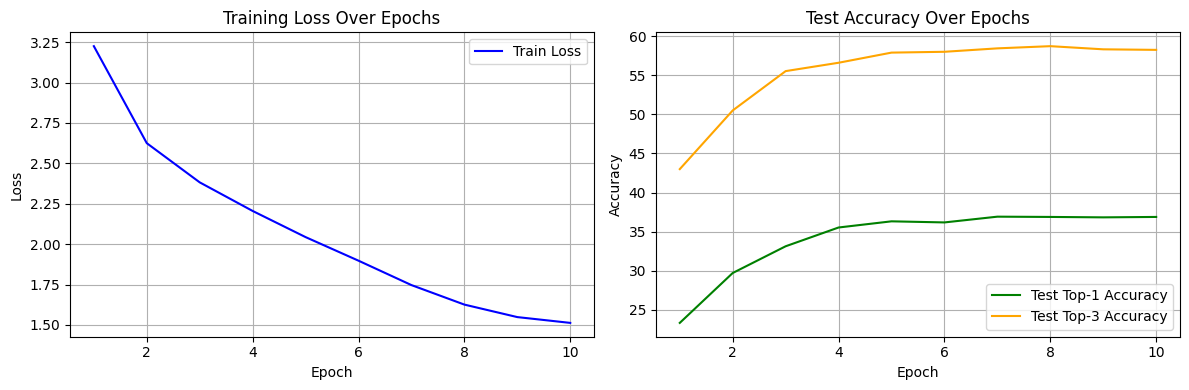

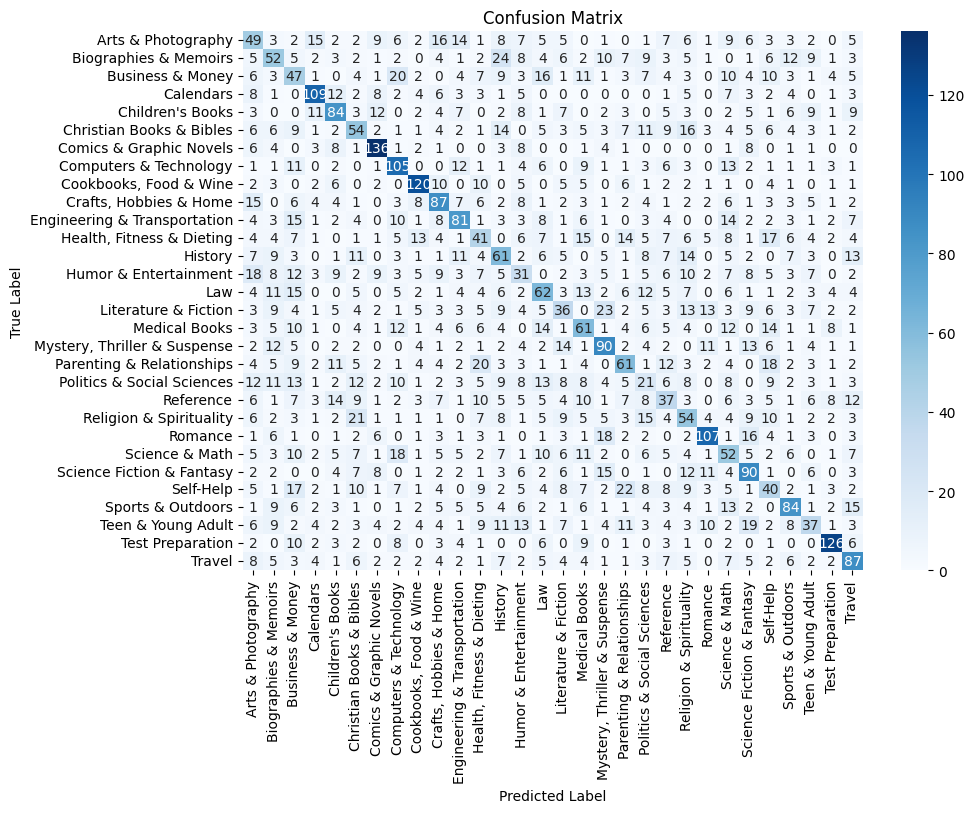

Figures saved to PVV/03_xyz-ycbcr2


In [16]:
class_names = list(label_names)
num_epochs=10

train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels = run_multiple_times(
    train_loader=train_loader,
    test_loader=test_loader, 
    num_epochs=num_epochs, 
    use_scheduler=True, 
    warmup = 0.2,
    num_runs=5
)

# Plot the results
plot_training_results(train_losses, test_accuracies_top1, test_accuracies_top3, all_preds, all_labels, output_dir)